In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
data = pd.read_excel('customer.xlsx',encoding='utf8')
data.head()

,顾客,购买日期,数量,购买总金额
0,C3,2017-09-28,1,16.99
1,C5,2017-05-03,3,37.47
2,C7,2017-07-22,9,138.50
3,C8,2017-07-29,2,24.46
4,C9,2017-10-08,2,41.98


In [28]:
data.info() #检查数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12757 entries, 0 to 12756
Data columns (total 4 columns):
顾客       12757 non-null object
购买日期     12757 non-null datetime64[ns]
数量       12757 non-null int64
购买总金额    12757 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 398.7+ KB


# 一、计算消费者的R（最近交易距离至今的天数）

In [35]:
from datetime import datetime as time
data_R = data.groupby('顾客').max()[['购买日期']]
data_R.rename(columns={'购买日期':'最后交易日期'},inplace=True)
data_R['最后一次交易距离天数'] =( time.now() - data_R['最后交易日期']).apply(lambda x:x.days)
data_R.head()

,最后交易日期,最后一次交易距离天数
顾客,,
C100,2017-08-20,145
C10018,2017-09-08,126
C1002,2017-09-07,127
C10026,2017-08-02,163
C10027,2017-08-23,142


#### 给客户打分：
  距离天数80天以内评5分
  
 距离天数110天以内评4分
 
 距离天数140天以内评3分
 
 距离天数170天以内评2分
 
 距离天数200天以内评1分
 

In [36]:
#评分函数
def Rscore(days):
    if days <= 80:
        return 5
    elif days <=110:
        return 4
    elif days <=140:
        return 3
    elif days <=170:
        return 2
    else:
        return 1

In [40]:
#添加评分列
data_R['R_Score'] = data_R['最后一次交易距离天数'].apply(Rscore)
data_R.head()


,最后交易日期,最后一次交易距离天数,R_Score
顾客,,,
C100,2017-08-20,145,2
C10018,2017-09-08,126,3
C1002,2017-09-07,127,3
C10026,2017-08-02,163,2
C10027,2017-08-23,142,2


In [43]:
data_R['R_Score'].value_counts()#客户的R得分分布

1    1858
4    1415
3     919
2     790
5     392
Name: R_Score, dtype: int64

## 二、计算每个客户的F（累计成交量）

In [45]:
data_F = data.groupby('顾客').sum()[['数量']]
data_F.head()

,数量
顾客,
C100,2
C10018,2
C1002,2
C10026,7
C10027,10


#### 给客户打分：
 成交量50个以上评5分
  
 成交量30个以上评4分
 
 成交量20个以上评3分
 
 成交量10个以上评2分
 
 成交量10个以内评1分

In [48]:
#评分函数
def Fscore(count):
    if count >= 50:
        return 5
    elif count >=30:
        return 4
    elif count >=20:
        return 3
    elif count >=10:
        return 2
    else:
        return 1

In [50]:
data_F['F_Score']=data_F['数量'].apply(Fscore)
data_F.head()

,数量,F_Score
顾客,,
C100,2,1
C10018,2,1
C1002,2,1
C10026,7,1
C10027,10,2


In [52]:
data_F['F_Score'].value_counts()#顾客的F得分分布

1    4523
2     583
3     155
4      70
5      43
Name: F_Score, dtype: int64

## 三、计算每个客户的M（累计成交额）

In [69]:
data_M = data.groupby('顾客').sum()[['购买总金额']]
data_M.head()

,购买总金额
顾客,
C100,28.98
C10018,23.37
C1002,15.48
C10026,123.43
C10027,122.33


#### 给客户打分：
 成交额500元以上评5分
  
 成交额300元以上500元以下评4分
 
 成交额150元以上300元以下评3分
 
 成交额50元以上150元以下评2分
 
 成交额50元以内评1分

In [70]:
#评分函数
def Mscore(amount):
    if amount >= 500:
        return 5
    elif amount >=300:
        return 4
    elif amount >=150:
        return 3
    elif amount >=50:
        return 2
    else:
        return 1

In [74]:
data_M['M_Score'] = data_M['购买总金额'].apply(Mscore)
data_M.head()

,购买总金额,M_Score
顾客,,
C100,28.98,1
C10018,23.37,1
C1002,15.48,1
C10026,123.43,2
C10027,122.33,2


In [76]:
data_M['M_Score'].value_counts()#顾客M分数分布

1    2810
2    1819
3     494
4     157
5      94
Name: M_Score, dtype: int64

## 四、计算三项均值

In [83]:
R_mean = data_R['R_Score'].mean()#R均值
F_mean = data_F['F_Score'].mean()#F均值
M_mean = data_M['M_Score'].mean()#M均值
print('R均值',R_mean,'\n'*2,'F均值',F_mean,'\n'*2,'M均值',M_mean)

R均值 2.570710829921846 

 F均值 1.2372534425009305 

 M均值 1.6799404540379606


## 五、判断顾客三项得分是否高于均值
  用RFM的每一项平均值作为判断高于还是低于，比如重要价值客户，必须是三项都高于平均值才能作为重要价值客户

In [96]:
#判定函数
def judge_R(r):
    if r > R_mean:
        return 1
    else:
        return 0

def judge_F(f):
    if f > F_mean:
        return 1
    else:
        return 0

def judge_M(m):
    if m > M_mean:
        return 1
    else:
        return 0

合并顾客的R,F,M分数

In [91]:
dataR = data_R.reset_index()[['顾客','R_Score']]
dataF = data_F.reset_index()[['顾客','F_Score']]
dataM = data_M.reset_index()[['顾客','M_Score']]
data_merge = dataR.merge(dataF,on='顾客',how='left').merge(dataM,on='顾客',how='left')
data_merge.head()

,顾客,R_Score,F_Score,M_Score
0,C100,2,1,1
1,C10018,3,1,1
2,C1002,3,1,1
3,C10026,2,1,2
4,C10027,2,2,2


判断顾客的R,F,M是否高于均值

In [98]:
data_merge['R均值判断'] = data_merge['R_Score'].apply(judge_R)
data_merge['F均值判断'] = data_merge['F_Score'].apply(judge_F)
data_merge['M均值判断'] = data_merge['M_Score'].apply(judge_M)
data_merge.head()

,顾客,R_Score,F_Score,M_Score,R均值判断,F均值判断,M均值判断
0,C100,2,1,1,0,0,0
1,C10018,3,1,1,1,0,0
2,C1002,3,1,1,1,0,0
3,C10026,2,1,2,0,0,1
4,C10027,2,2,2,0,1,1


## 六、通过判断进行顾客分类

In [101]:
R = data_merge['R均值判断']
F = data_merge['F均值判断']
M = data_merge['M均值判断']

data_merge['客户价值分类'] = np.where((R==1)&(F==1)&(M==1),'重要价值客户',
                                np.where((R==0)&(F==1)&(M==1),'重要召回客户',
                                         np.where((R==1)&(F==0)&(M==1),'重要维护客户',
                                                  np.where((R==0)&(F==0)&(M==1),'重要挽留客户',
                                                           np.where((R==1)&(F==1)&(M==0),'潜力客户',
                                                                    np.where((R==1)&(F==0)&(M==0),'新客户',
                                                                             np.where((R==0)&(F==1)&(M==0),'一般客户',
                                                                                     '流失客户')))))))
data_merge.head()

,顾客,R_Score,F_Score,M_Score,R均值判断,F均值判断,M均值判断,客户价值分类
0,C100,2,1,1,0,0,0,流失客户
1,C10018,3,1,1,1,0,0,新客户
2,C1002,3,1,1,1,0,0,新客户
3,C10026,2,1,2,0,0,1,重要挽留客户
4,C10027,2,2,2,0,1,1,重要召回客户


## 七、数据可视化

In [104]:
custom_classify = data_merge['客户价值分类'].value_counts()
custom_classify

流失客户      1750
新客户       1060
重要维护客户     990
重要挽留客户     723
重要价值客户     676
重要召回客户     175
Name: 客户价值分类, dtype: int64

[Text(0.5,1,'客户价值分类占比')]

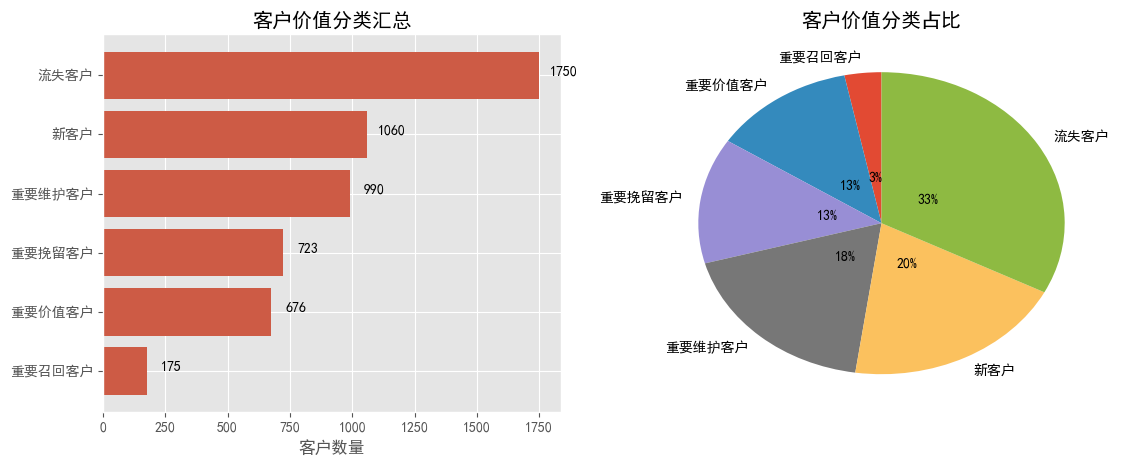

In [165]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(13,5),dpi = 100)
plot1 = fig.add_subplot(121)
plot2 = fig.add_subplot(122)
plt.rcParams['font.sans-serif']=['SimHei']#定义画图工具

x = custom_classify.sort_values().index
y = custom_classify.sort_values().values

plot1.barh(np.arange(len(x)),y,tick_label = x,color = '#CD5B45' )
plot1.set(xlabel = '客户数量',title='客户价值分类汇总')
for a,b in zip(y,np.arange(len(x))):
    plot1.text(a+100,b,a,ha='center',fontsize=10)
plot2.pie(y,labels=x,startangle=90,autopct='%.f%%',pctdistance=0.3)
plot2.set(title='客户价值分类占比')

> 分析：
从图表中可以看出流失客户1750人，占全部客户的33%，而与之对应的新客户有1060人占比20%，说明在客户数量处于净流失达到13%。需要进一步对产品经营的现状做进一步的调查，了解流失客户的原因。而对于经营收益影响最大的重要价值客户有676人，占总客户的13%，这些才是公司的主要盈利对象，需要对这些客户有更多的照顾和活动，进而提高订单额；公司新客户也有着较大的占比可以尝试加大宣传的力度，稳定提高新客户的增长量。

### 客户贡献度分析

贡献度分析又称为帕累托分析，原理是帕累托法则，又称28法则；
例如80%的收入来自20%的客户，80%的财富掌握在20%的人手中

In [146]:
#得到各类型客户的贡献金额
custom_cost = pd.merge(data_merge,data_M.reset_index().loc[:,'顾客':'购买总金额'],on='顾客',how='left')
custom_cost = custom_cost.groupby('客户价值分类').sum()['购买总金额']
custom_cost

客户价值分类
新客户        29484.31
流失客户       44709.49
重要价值客户    217689.33
重要召回客户     36597.66
重要挽留客户     60729.00
重要维护客户     86944.58
Name: 购买总金额, dtype: float64

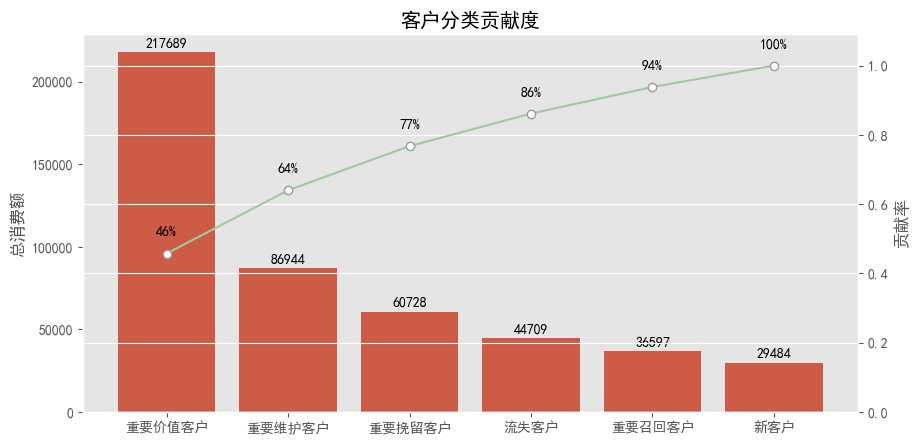

In [187]:
plt.rcParams['font.sans-serif']=['SimHei']

x = custom_cost.sort_values(ascending=False).index
y = custom_cost.sort_values(ascending = False).values

fig,plot3 = plt.subplots(figsize=(10,5),dpi = 100)
plot3.bar(np.arange(len(x)),y,tick_label = x,color = '#CD5B45')
plot3.set(title='客户分类贡献度',ylabel = '总消费额')
for a,b in zip(np.arange(len(x)),y):
    plot3.text(a,b+3000,int(b),ha='center',fontsize = 10)
plot3.grid(False)
plot4 = plot3.twinx()
cumsum_cost = y.cumsum()/y.sum()
plot4.plot(np.arange(len(x)),cumsum_cost,marker='o',color='#9BCD9B',mec='#9C9C9C',mfc='white')
plot4.set_ylim(0,1.09)
plot4.set_ylabel('贡献率')
for a,b in zip(np.arange(len(x)),cumsum_cost):
    plot4.text(a,b+0.05,format(b,'.0%'),ha='center',fontsize = 10)

> 分析：
重要价值客户虽然只占所有客户的13%，但是所贡献的订单额达到了46%，将近总体的一半贡献度，其行为本身具有较高的粘性，但是还是要保持客户的经营，避免流失重要价值客户；占比第二客户则是重要维护的客户，他们自身具有交易额大，但是交易频率低的特征，说明这类客户消费能力强，但是没有激活粘性，需要更具体的了解该类客户的需求，并提供相应的服务，使之转化为重要价值客户。

## 八、导出客户分类

In [201]:

for i in x:
    save = data_merge.loc[data_merge['客户价值分类'] == i][['顾客','客户价值分类']]
    save.to_csv(i + '.csv')
